<a href="https://colab.research.google.com/github/akshaypat444/tensorflow_practice/blob/main/08_natural_language_processing_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Fri Mar  8 02:50:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-08 02:52:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-08 02:52:41 (122 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys, unzip_data

## Get the data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data('nlp_getting_started.zip')

--2024-03-08 02:55:53--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.207, 64.233.189.207, 108.177.97.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K   978KB/s    in 0.6s    

2024-03-08 02:55:54 (978 KB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [14]:
train_data= pd.read_csv('train.csv')
test_data= pd.read_csv('test.csv')

In [15]:
train_data.shape, test_data.shape

((7613, 5), (3263, 4))

In [16]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [11]:
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Pre-process data

In [17]:
train_data = train_data.drop('keyword', axis=1).drop('location', axis=1).drop('id', axis=1)
test_data = test_data.drop('location', axis=1).drop('id', axis=1).drop('keyword', axis=1)

In [18]:
train_data.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [20]:
# Need to shuffle since target is 1 and then 0
train_df_shuffled = train_data.sample(frac=1, random_state=42)
train_df_shuffled.head()

,text,target
2644,So you have a new weapon that can cause un-ima...,1
2227,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,Aftershock back to school kick off was great. ...,0
6845,in response to trauma Children of Addicts deve...,0


In [23]:
# Check if data is imbalanced
train_data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [30]:
import random
random_index = random.randint(0, len(train_df_shuffled)-5)

for row in train_df_shuffled[random_index:random_index+5].itertuples():
  print(row.target)
  print(row.text)
  print('\n')

0
This is Lara she likes sinking her teeth into my flesh and clawing my arms ?????? http://t.co/J43NWkX0X3


1
ÛÏ@BBCEngland: A burst water main causes major flooding at a Birmingham hospital http://t.co/q4kGftC2AM http://t.co/6w6A2L4qAeÛ OMG.


1
Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute http://t.co/rkU0IDM6aQ


1
The Latest: More homes razed by #NorthernCalifornia wildfire http://t.co/mONiJJth7V #ZippedNews http://t.co/0yXBB5dzw5


0
when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????




## Split data into training and validation dataset

In [41]:
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                  train_df_shuffled["target"].to_numpy(),
                                                  test_size=0.1, random_state=42)
print(train_sentences.shape)
print(val_sentences.shape)
print(train_labels.shape)
print(val_labels.shape)

(6851,)
(762,)
(6851,)
(762,)


## Converting text to numbers
1. Tokenization - straight mapping to numbers
2. Embeddings - richer representations of the relationships between tokens

### 1. Tokenization (Text Vectorization)

In [43]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# These are default values
text_vectorizer = TextVectorization(max_tokens=None, # How many words in the vocabulary
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # Create groups of n-words
                                    output_mode="int",
                                    output_sequence_length=None, # Pads to the longest sequence
                                    pad_to_max_tokens=True)

In [45]:
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [46]:
max_vocab_length = 10000 # max number of words to have in vocabulary
max_length = 15  # max length of sequence i.e. tweet

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)
# Fit the text vectorizer
train_vectorized = text_vectorizer.adapt(train_sentences)

In [52]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [54]:
# Convert random sentence from training dataset and convert it to vector of int
# using vectorizer
random_sentence = random.choice(train_sentences)
print(random_sentence)
print(text_vectorizer([random_sentence]))

@tsunami_esh ?? hey Esh
tf.Tensor(
[[4366  706 5710    0    0    0    0    0    0    0    0    0    0    0
     0]], shape=(1, 15), dtype=int64)


In [56]:
# Get the unique words in vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print("Top 5 words: ", top_5_words)
print("Bottom 5 words: ", bottom_5_words)

Top 5 words:  ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 words:  ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [59]:
# Vocabulary size
len(words_in_vocab)

10000

### 3. Embedding layer - Dense vector representation

1. `input_dim` = size of vocabulary (1000 here)
2. `output_dim` = output vector size (may be 100)
3. `input_length` = length of sentence or sequence

In [60]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # 10000
                             output_dim=128,
                             input_length=max_length  # 15
                             )
embedding

In [61]:
random_sentence = random.choice(train_sentences)
embedded_text = embedding(text_vectorizer(random_sentence))
print(random_sentence)
print(embedded_text)
print(embedded_text.shape)

Trusting Iran to stop terrorism is like inviting an arsonist to join the fire brigade - Telegraph http://t.co/2Z2HTDjQZD
tf.Tensor(
[[ 0.02509917 -0.02078468 -0.04951242 ...  0.03214012  0.0178376
   0.02583407]
 [ 0.02249228  0.01809652 -0.03646847 ... -0.01975709 -0.02663734
   0.01496423]
 [ 0.02491912 -0.01629028  0.03776577 ... -0.03892823  0.03259188
  -0.00338854]
 ...
 [-0.04027703  0.03234753  0.020752   ...  0.02090326  0.0483891
  -0.00046049]
 [ 0.01528862  0.00531973 -0.02290191 ...  0.03287554 -0.00778355
  -0.02976803]
 [-0.04488139  0.03235103 -0.03727489 ...  0.00282628  0.01814424
  -0.0413852 ]], shape=(15, 128), dtype=float32)
(15, 128)


In [62]:
# The embedding weights will get updated as we train the model

## Model 0 - Naive Bayes baseline

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [96]:
# Evaluate the baseline model
baseline_score = model_0.score(val_sentences, val_labels)
baseline_score

0.7926509186351706

In [97]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [94]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(true_labels, preds):
  return {"accuracy": accuracy_score(true_labels, preds) * 100,
          "precision": precision_score(true_labels, preds) * 100,
          "recall": recall_score(true_labels, preds) * 100,
          "f1": f1_score(true_labels, preds) * 100}

In [98]:
baseline_results = calculate_metrics(val_labels, baseline_preds)

## Model 1: Dense neural network

In [83]:
# Create a tensorboard callback
from helper_functions import create_tensorboard_callback, plot_loss_curves

SAVE_DIR = "model_logs"

In [80]:
from tensorflow.keras import layers

inputs= layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_1  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 1280129 (

In [81]:
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: model_logs/model_1_dense/20240308-050440
Epoch 1/5
215/215 [==============================] - 7s 29ms/step - loss: 0.5205 - accuracy: 0.8257 - val_loss: 0.4965 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3412 - accuracy: 0.8878 - val_loss: 0.4535 - val_accuracy: 0.7927
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2707 - accuracy: 0.9064 - val_loss: 0.4546 - val_accuracy: 0.7940
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.2286 - accuracy: 0.9209 - val_loss: 0.4762 - val_accuracy: 0.7953
Epoch 5/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1989 - accuracy: 0.9301 - val_loss: 0.4864 - val_accuracy: 0.7861


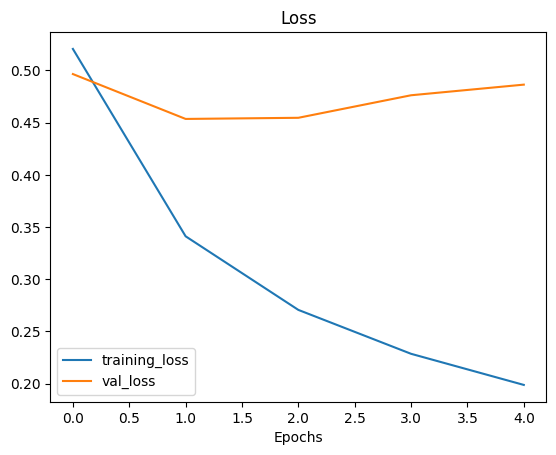

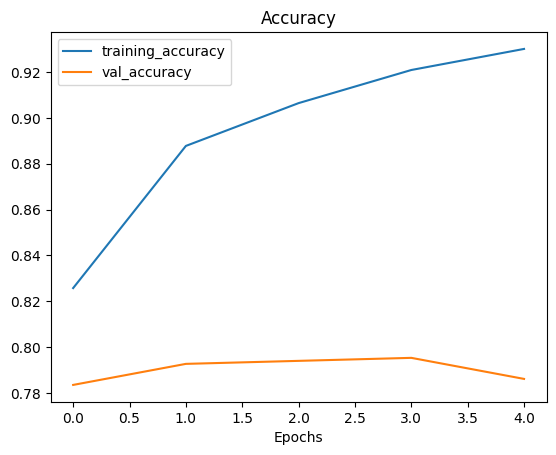

In [84]:
plot_loss_curves(model_1_history)

In [99]:
model_1_preds = model_1.predict(val_sentences)
model_1_preds = tf.squeeze(tf.round(model_1_preds)).numpy()
model_1_results = calculate_metrics(val_labels, model_1_preds)

24/24 [==============================] - 0s 2ms/step


In [101]:
baseline_results, model_1_results

({'accuracy': 79.26509186351706,
  'precision': 88.6178861788618,
  'recall': 62.643678160919535,
  'f1': 73.4006734006734},
 {'accuracy': 78.60892388451444,
  'precision': 81.78694158075601,
  'recall': 68.39080459770115,
  'f1': 74.49139280125196})